In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
from scipy.ndimage import gaussian_filter
import matplotlib

import pickle 
import colorsys
import random

In [3]:
neural = sc.read_h5ad('../data/neural_data_0606.h5ad')

state_path = '../models/neural_vf_0606_model.pt'

vt.md.Velvet.setup_anndata(neural, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    neural,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)

INFO     Generating sequential column names                                                  


<All keys matched successfully>

In [4]:
model.module = model.module.to('cuda')

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

markov = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True, 
    use_similarity=False
)

sde = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.1,
    device=model.device
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde,
    markov,
)


sde_state_path = '../models/neural_sde_0606_model.pt'

trained_state_sde = torch.load(sde_state_path)['model_state_dict']

sde_model.module.load_state_dict(trained_state_sde)

KNN indices for Velvet stored in .obsm['knn_index'].


<All keys matched successfully>

In [7]:
import pickle 

with open('../data/F4_noisy0.0_trajectories.pickle', 'rb') as f:
    data = pickle.load(f)
    
mn_gex = model.get_trajectory_gene_expression(data["MN"])
fp_gex = model.get_trajectory_gene_expression(data["FP"])
v3_gex = model.get_trajectory_gene_expression(data["V3"])

# clustermap

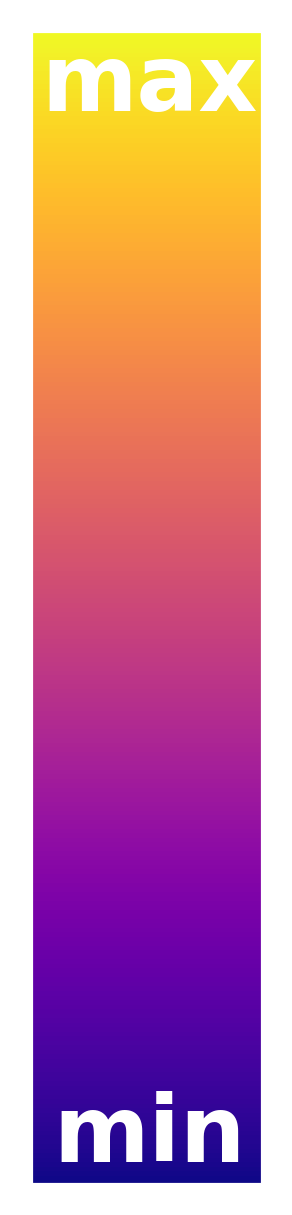

In [363]:
import matplotlib as mpl

# Create a colormap
cmap = mpl.cm.plasma

# Create a Normalize object
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# Create a new figure
fig, ax = plt.subplots(figsize=(1, 5), dpi=300)

# Create a Colorbar
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')

ax.text(0.1,0.02,'min', color='white', fontweight='bold', fontsize=22)
ax.text(0.05,0.93,'max', color='white', fontweight='bold', fontsize=22)
ax.set_yticks([],[])

plt.savefig('../figures/4.1.14_colorbar.png', bbox_inches='tight')
plt.show()

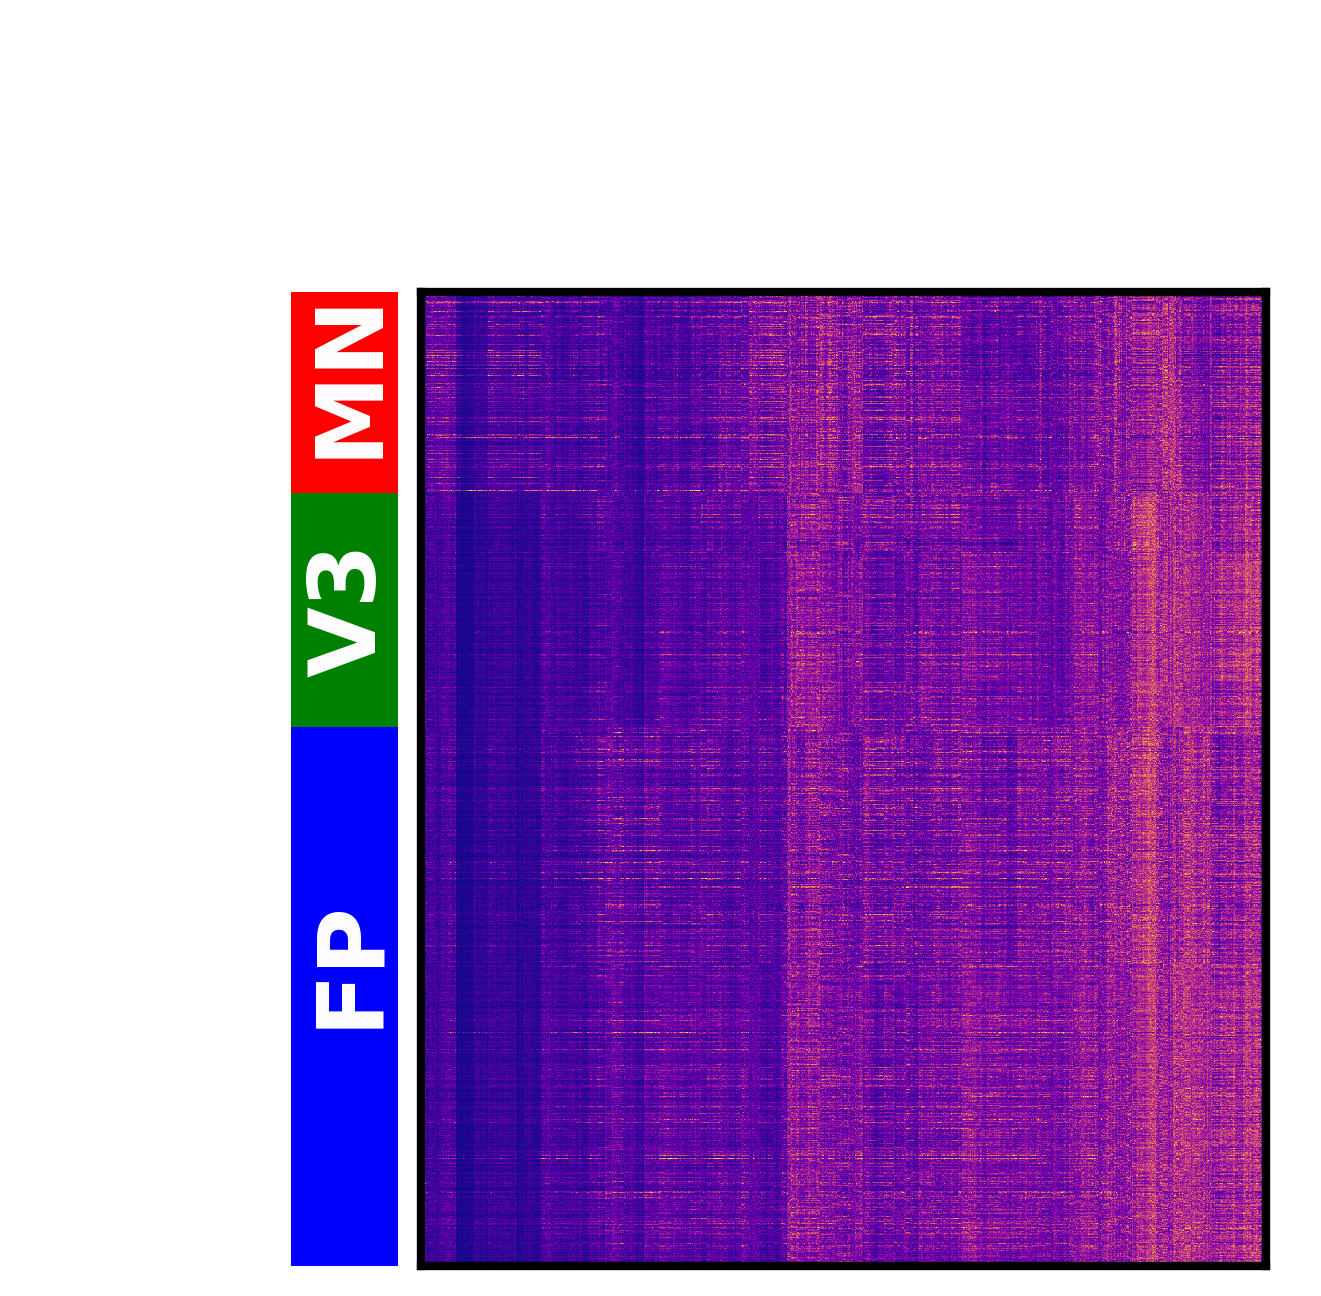

In [30]:
t = 0

clust = torch.vstack(
    (mn_gex[:,t,:],
    v3_gex[:,t,:],
    fp_gex[:,t,:])
).detach().cpu().numpy()

obslist = ['MN']*mn_gex.shape[0]+['V3']*v3_gex.shape[0]+['FP']*fp_gex.shape[0]

col_df = {'MN':'red','V3':'green','FP':'blue'}

g = sns.clustermap(
    clust, 
    standard_scale=1, 
    row_cluster=False, 
    row_colors=[col_df[o] for o in obslist], 
    cmap='plasma',
    figsize=(5,5),
    colors_ratio=0.09,
)

g.cax.remove()

fig = plt.gcf()
fig.set_dpi(300)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(g.ax_heatmap.get_yticklabels(), visible=False)
g.ax_col_dendrogram.collections[0].set_alpha(0.0)
g.ax_heatmap.set(yticks=[])
g.ax_heatmap.set(xticks=[])

for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

# plt.savefig('../figures/4.1.15_t0_clustermap.png', bbox_inches='tight')
ax.text(-190,500, 'MN', rotation=90, fontweight='bold', fontsize=22, color='white')
ax.text(-190,1250, 'V3', rotation=90, fontweight='bold', fontsize=22, color='white')
ax.text(-190,2450, 'FP', rotation=90, fontweight='bold', fontsize=22, color='white')

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

plt.savefig('../figures/4.1.15_clust_t0.png', bbox_inches='tight')
plt.show()

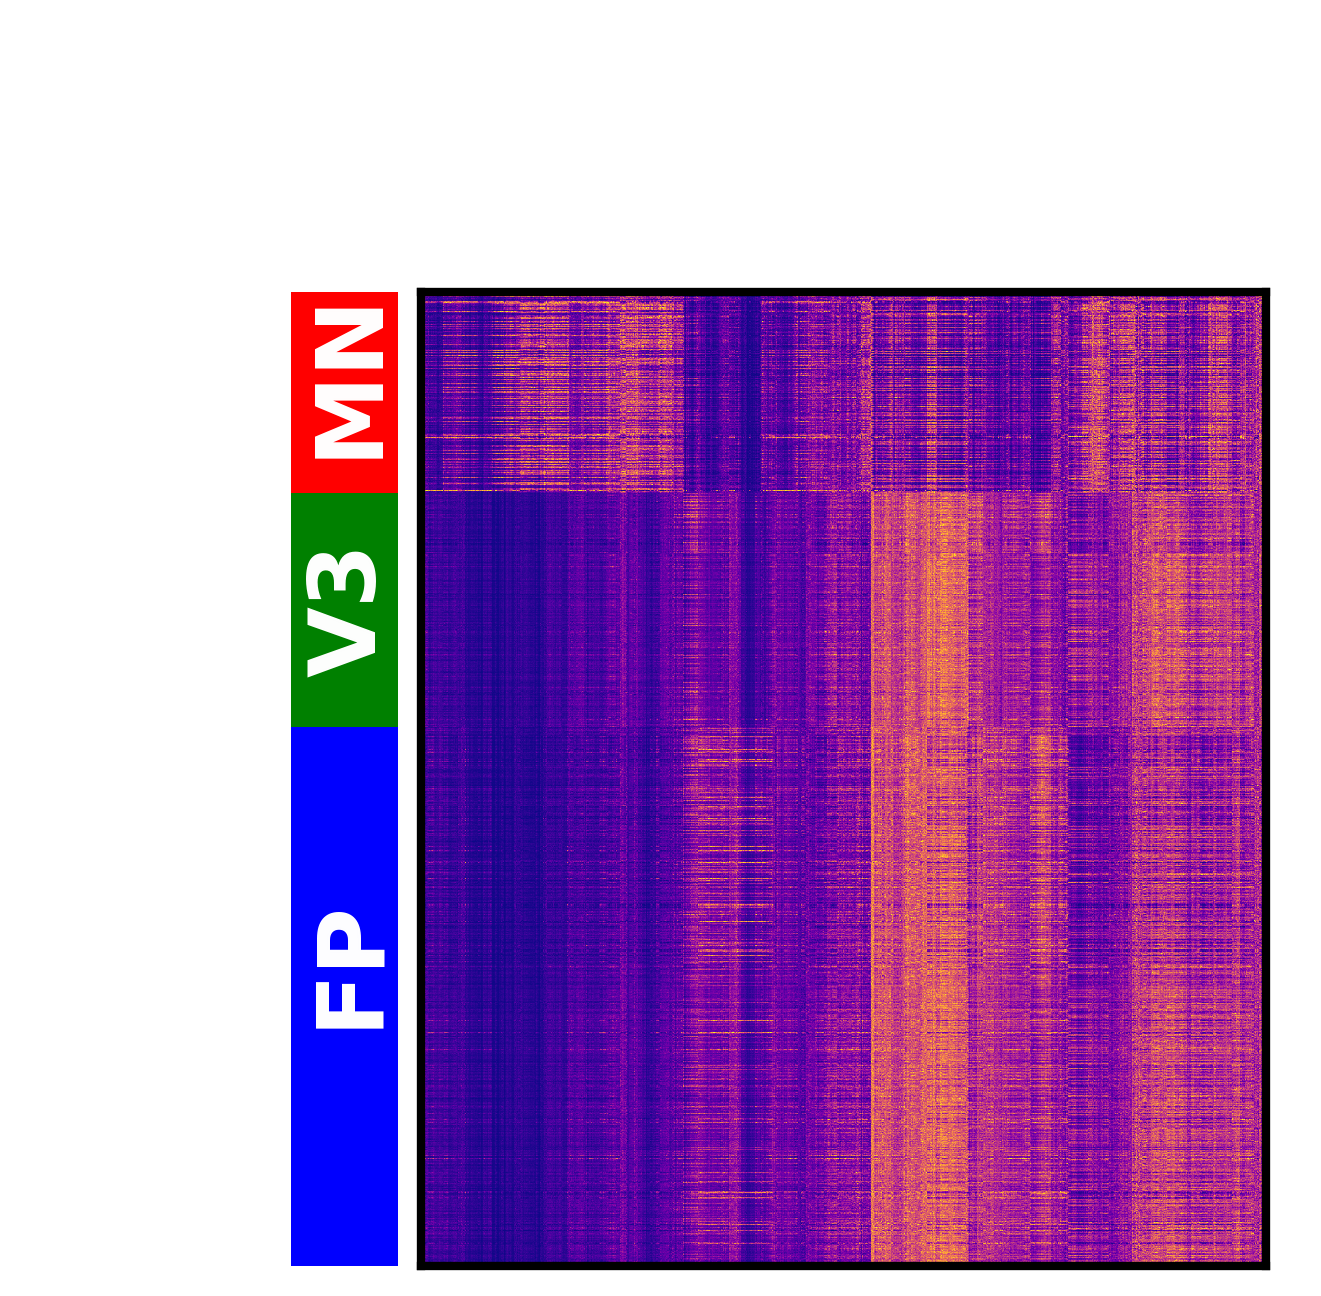

In [31]:
t = 20

clust = torch.vstack(
    (mn_gex[:,t,:],
    v3_gex[:,t,:],
    fp_gex[:,t,:])
).detach().cpu().numpy()

obslist = ['MN']*mn_gex.shape[0]+['V3']*v3_gex.shape[0]+['FP']*fp_gex.shape[0]

col_df = {'MN':'red','V3':'green','FP':'blue'}

g = sns.clustermap(
    clust, 
    standard_scale=1, 
    row_cluster=False, 
    row_colors=[col_df[o] for o in obslist], 
    cmap='plasma',
    figsize=(5,5),
    colors_ratio=0.09,
)

g.cax.remove()

fig = plt.gcf()
fig.set_dpi(300)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(g.ax_heatmap.get_yticklabels(), visible=False)
g.ax_col_dendrogram.collections[0].set_alpha(0.0)
g.ax_heatmap.set(yticks=[])
g.ax_heatmap.set(xticks=[])

for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

# plt.savefig('../figures/4.1.15_t0_clustermap.png', bbox_inches='tight')
ax.text(-190,500, 'MN', rotation=90, fontweight='bold', fontsize=22, color='white')
ax.text(-190,1250, 'V3', rotation=90, fontweight='bold', fontsize=22, color='white')
ax.text(-190,2450, 'FP', rotation=90, fontweight='bold', fontsize=22, color='white')

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

plt.savefig('../figures/4.1.15_clust_t20.png', bbox_inches='tight')
plt.show()

In [32]:
t = 50

clust = torch.vstack(
    (mn_gex[:,t,:],
    v3_gex[:,t,:],
    fp_gex[:,t,:])
).detach().cpu().numpy()

obslist = ['MN']*mn_gex.shape[0]+['V3']*v3_gex.shape[0]+['FP']*fp_gex.shape[0]

col_df = {'MN':'red','V3':'green','FP':'blue'}

g = sns.clustermap(
    clust, 
    standard_scale=1, 
    row_cluster=False, 
    row_colors=[col_df[o] for o in obslist], 
    cmap='plasma',
    figsize=(5,5),
    colors_ratio=0.09,
)

g.cax.remove()

fig = plt.gcf()
fig.set_dpi(300)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
plt.setp(g.ax_heatmap.get_yticklabels(), visible=False)
g.ax_col_dendrogram.collections[0].set_alpha(0.0)
g.ax_heatmap.set(yticks=[])
g.ax_heatmap.set(xticks=[])

for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(2)


for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')

# plt.savefig('../figures/4.1.15_t0_clustermap.png', bbox_inches='tight')
ax.text(-190,500, 'MN', rotation=90, fontweight='bold', fontsize=22, color='white')
ax.text(-190,1250, 'V3', rotation=90, fontweight='bold', fontsize=22, color='white')
ax.text(-190,2450, 'FP', rotation=90, fontweight='bold', fontsize=22, color='white')

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

plt.savefig('../figures/4.1.15_clust_t50.png', bbox_inches='tight')
plt.show()